In [ ]:
import os
import pandas as pd
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load Data from csv

The dataset I have chosen to use is the Citeseer dataset. It contains 3,312 scientific publications classified into one of six classes, and there are 4,732 links in the network. Each publication is represented by a binary word vector of size 3,703.

The dataset has two separate files:
1. `citeseer.cites`: This file contains the citation graph with two columns:
  - `cited_paper_id`: target
  - `citing_paper_id`: source
2. `citeseer.content`: This file contains the descriptions of papers with 3,705 columns:
  - `paper_id`
  - `word_attributes`: 3,703 binary features
  - `class_label`: target label that we're trying to predict.

In [ ]:
import urllib.request
import tarfile
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops

In [ ]:
url = "https://linqs-data.soe.ucsc.edu/public/lbc/citeseer.tgz"
save_path = "./data/citeseer.tgz"
data_dir = os.path.join(os.path.dirname(save_path), "citeseer")

os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [ ]:
# Download file
urllib.request.urlretrieve(url, save_path)

('./data/citeseer.tgz', <http.client.HTTPMessage at 0x7c0bc6858910>)

In [ ]:
# Extract file
with tarfile.open(save_path, "r") as tar:
  tar.extractall(path=os.path.dirname(save_path))

In [ ]:
# Import citations file as a dataframe
df_citations = pd.read_csv(
    os.path.join(data_dir, "citeseer.cites"),
    sep="\t",
    header=None,
    names=["cited_paper_id", "citing_paper_id"],
)

print(df_citations.shape)
df_citations.head()

(4732, 2)


,cited_paper_id,citing_paper_id
0,100157,100157
1,100157,364207
2,100157,38848
3,100157,bradshaw97introduction
4,100157,bylund99coordinating


In [ ]:
df_citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4732 entries, 0 to 4731
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cited_paper_id   4732 non-null   object
 1   citing_paper_id  4732 non-null   object
dtypes: object(2)
memory usage: 74.1+ KB


Since the citations data contains paper_id's in both

In [ ]:
# Import contents dataframe
df_papers = pd.read_csv(
    os.path.join(data_dir, "citeseer.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"feature_{idx}" for idx in range(3703)] + ["class_label"]
)

print(df_papers.shape)
df_papers.head()

(3312, 3705)


<ipython-input-9-83045d0f8858>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_papers = pd.read_csv(


,paper_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_3694,feature_3695,feature_3696,feature_3697,feature_3698,feature_3699,feature_3700,feature_3701,feature_3702,class_label
0,100157,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Agents
1,100598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,IR
2,105684,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Agents
3,11099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DB
4,114091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AI


In [ ]:
df_papers.paper_id.nunique()

3312

In [ ]:
df_agg_classes = pd.DataFrame(df_papers.class_label.value_counts(normalize=True)).reset_index()
df_agg_classes

,class_label,proportion
0,DB,0.211655
1,IR,0.201691
2,Agents,0.179952
3,ML,0.178140
4,HCI,0.153382
5,AI,0.075181


Text(0.5, 1.0, '% of Papers by Class Label')

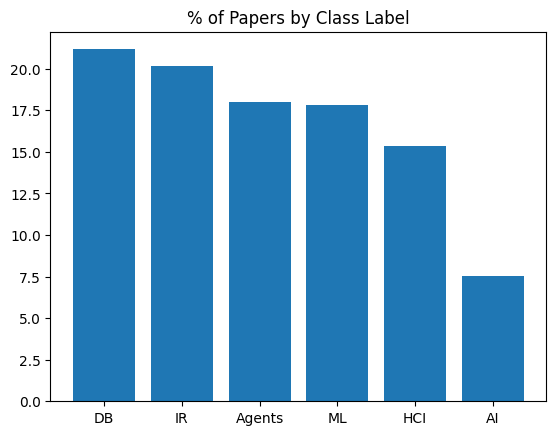

In [ ]:
plt.bar(
    x=df_agg_classes.class_label,
    height=df_agg_classes.proportion.apply(lambda x: x * 100)
)
plt.title("% of Papers by Class Label")

In [ ]:
df_papers["paper_id"].nunique()

3312

In [ ]:
# Only include cited and citing papers that are in df_papers
df_citations_filtered = df_citations[df_citations["cited_paper_id"].isin(df_papers["paper_id"])]
df_citations_filtered = df_citations_filtered[df_citations_filtered["citing_paper_id"].isin(df_papers["paper_id"])]

print(df_citations_filtered.shape)

(3298, 2)


In [ ]:
# Convert paper_id's to numeric data types in order to create tensors
unique_paper_ids = pd.concat(
    [df_papers["paper_id"], df_citations_filtered["cited_paper_id"], df_citations_filtered["citing_paper_id"]]
).drop_duplicates().astype("category")
combined_categories = unique_paper_ids.cat.categories

paper_id_to_code = pd.DataFrame({
    "paper_id": combined_categories,
    "cited_paper_node": pd.Categorical(combined_categories, categories=combined_categories).codes
})

paper_id_to_code.sample(5)

,paper_id,cited_paper_node
1298,bradford99characterization,1298
768,467320,768
85,51542,85
3272,yu01indexing,3272
2557,oakley00putting,2557


In [ ]:
df_papers["paper_code"] = pd.Categorical(df_papers["paper_id"], categories=combined_categories).codes
df_citations_filtered["cited_paper_code"] = pd.Categorical(df_citations_filtered["cited_paper_id"], categories=combined_categories).codes
df_citations_filtered["citing_paper_code"] = pd.Categorical(df_citations_filtered["citing_paper_id"], categories=combined_categories).codes

df_citations_filtered.head()

,cited_paper_id,citing_paper_id,cited_paper_code,citing_paper_code
15,101570,krasnogor00memetic,512,2172
17,10227,sima00computational,513,2920
18,10227,sima01computational,513,2921
19,103027,140169,515,548
21,106003,104129,518,517


In [ ]:
# Convert class_labels to numeric data types in order to create tensors
label_categories = df_papers["class_label"].astype("category").cat.categories

class_label_to_code = pd.DataFrame({
    "class_label": label_categories,
    "class_label_code": pd.Categorical(label_categories, categories=label_categories).codes
})

class_label_to_code

,class_label,class_label_code
0,AI,0
1,Agents,1
2,DB,2
3,HCI,3
4,IR,4
5,ML,5


In [ ]:
df_papers["class_label_code"] = pd.Categorical(df_papers["class_label"], categories=label_categories).codes

df_papers.head()

,paper_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_3696,feature_3697,feature_3698,feature_3699,feature_3700,feature_3701,feature_3702,class_label,paper_code,class_label_code
0,100157,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Agents,88,1
1,100598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,IR,89,4
2,105684,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Agents,90,1
3,11099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,DB,12,2
4,114091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,AI,91,0


In [ ]:
# Extract node features from df
features = [col for col in df_papers if "feature_" in col]

x = torch.tensor(df_papers[features].values, dtype=torch.float32)

In [ ]:
# Extract edge indices and tensor
edges = torch.tensor(df_citations_filtered[["cited_paper_code", "citing_paper_code"]].values, dtype=torch.long)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Remove duplicate edges and self loops
edge_index = remove_self_loops(edge_index)[0]

edge_index.shape

<ipython-input-20-ca47ef796617>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


torch.Size([2, 3187])

In [ ]:
# Extract labels from df
y = torch.tensor(df_papers["class_label_code"].values, dtype=torch.long)

In [ ]:
# Create homogeneous graph using PyTorch's Data object
data = Data(x=x, edge_index=edge_index, y=y)

print(data)

Data(x=[3312, 3703], edge_index=[2, 3187], y=[3312])


# Train/ test Split

In [ ]:
# Nodes
num_nodes = data.num_nodes
train_percentage = 0.7
num_train_nodes = int(train_percentage * num_nodes)

# labels
num_classes = torch.unique(data.y).size(0)
data.num_classes = num_classes

print("# of nodes: ", num_nodes, "\n# of train nodes: ", num_train_nodes, "\n# of classes: ", num_classes)

# of nodes:  3312 
# of train nodes:  2318 
# of classes:  6


In [ ]:
# Create a boolean mask to indicate whether node is in training set
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[: num_train_nodes] = True

In [ ]:
# Add train mask to data object
data.train_mask = train_mask

# Create test mask that is the inverse of train mask
test_mask = ~data.train_mask
data.test_mask = test_mask

data

Data(x=[3312, 3703], edge_index=[2, 3187], y=[3312], num_classes=6, train_mask=[3312], test_mask=[3312])

## Train Multi-layer Perceptron Network (MLP)

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [ ]:

class MLP(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(123)
    self.lin1 = Linear(data.num_features, hidden_channels)
    self.lin2 = Linear(hidden_channels, hidden_channels)
    self.lin3 = Linear(hidden_channels, data.num_classes)

  def forward(self, x):
    x = self.lin1(x)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.lin2(x)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.lin3(x)
    return x

In [ ]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(model)

MLP(
  (lin1): Linear(in_features=3703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=6, bias=True)
)


In [ ]:
# Helper function for visualization
def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(10, 10))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")

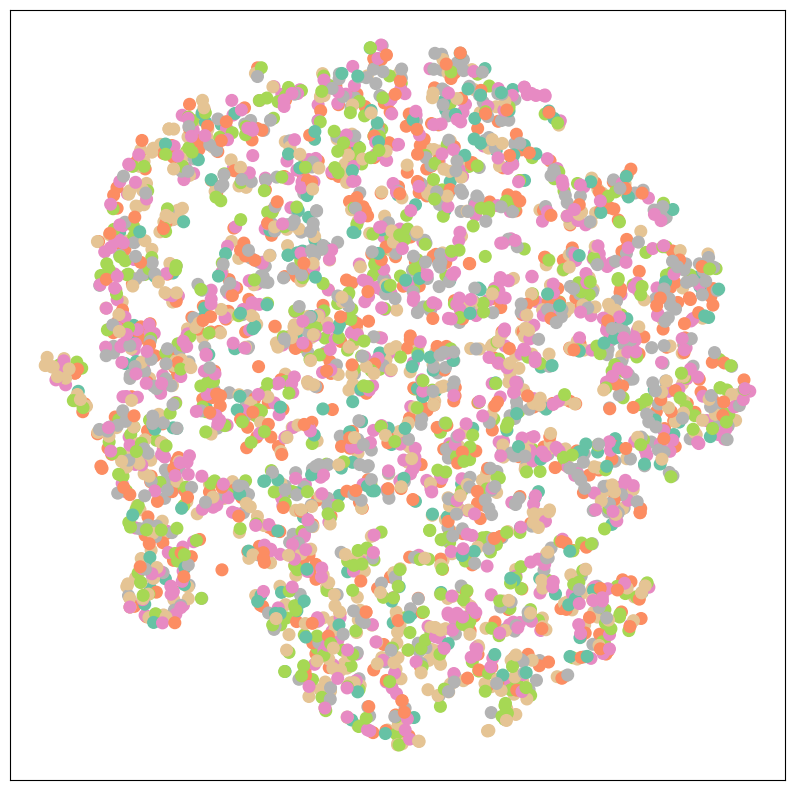

In [ ]:
# Visualize nodes and labels before training
model.eval()
out = model(data.x)
visualize(out, color=data.y)

In [ ]:
def train():
  model.train()
  optimizer.zero_grad()   # Clear gradients
  out = model(data.x)   # Perform a single forward pass
  loss = criterion(out[data.train_mask], data.y[data.train_mask])   # Compute loss solely based on training nodes
  loss.backward()   # Derive gradients
  optimizer.step()    # Update parameters based on gradients
  return loss

In [ ]:
def test():
  model.eval()
  out = model(data.x)
  pred = out.argmax(dim=1)  # Use class with highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask]   # Check against ground-truth labels
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Calculate ratio of correct predictions
  return test_acc

In [ ]:
for epoch in range(1, 101):
  loss = train()
  print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 001, Loss: 1.7945
Epoch: 002, Loss: 1.7605
Epoch: 003, Loss: 1.7262
Epoch: 004, Loss: 1.6804
Epoch: 005, Loss: 1.6334
Epoch: 006, Loss: 1.5878
Epoch: 007, Loss: 1.5362
Epoch: 008, Loss: 1.4896
Epoch: 009, Loss: 1.4234
Epoch: 010, Loss: 1.3811
Epoch: 011, Loss: 1.3267
Epoch: 012, Loss: 1.2845
Epoch: 013, Loss: 1.2386
Epoch: 014, Loss: 1.1903
Epoch: 015, Loss: 1.1151
Epoch: 016, Loss: 1.0817
Epoch: 017, Loss: 1.0518
Epoch: 018, Loss: 1.0200
Epoch: 019, Loss: 0.9630
Epoch: 020, Loss: 0.9433
Epoch: 021, Loss: 0.9155
Epoch: 022, Loss: 0.8816
Epoch: 023, Loss: 0.8316
Epoch: 024, Loss: 0.8492
Epoch: 025, Loss: 0.7868
Epoch: 026, Loss: 0.7587
Epoch: 027, Loss: 0.7366
Epoch: 028, Loss: 0.6990
Epoch: 029, Loss: 0.7056
Epoch: 030, Loss: 0.6870
Epoch: 031, Loss: 0.6610
Epoch: 032, Loss: 0.6784
Epoch: 033, Loss: 0.6307
Epoch: 034, Loss: 0.6310
Epoch: 035, Loss: 0.6269
Epoch: 036, Loss: 0.6215
Epoch: 037, Loss: 0.6080
Epoch: 038, Loss: 0.5851
Epoch: 039, Loss: 0.5934
Epoch: 040, Loss: 0.5722


In [ ]:
test_acc = test()
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.6147


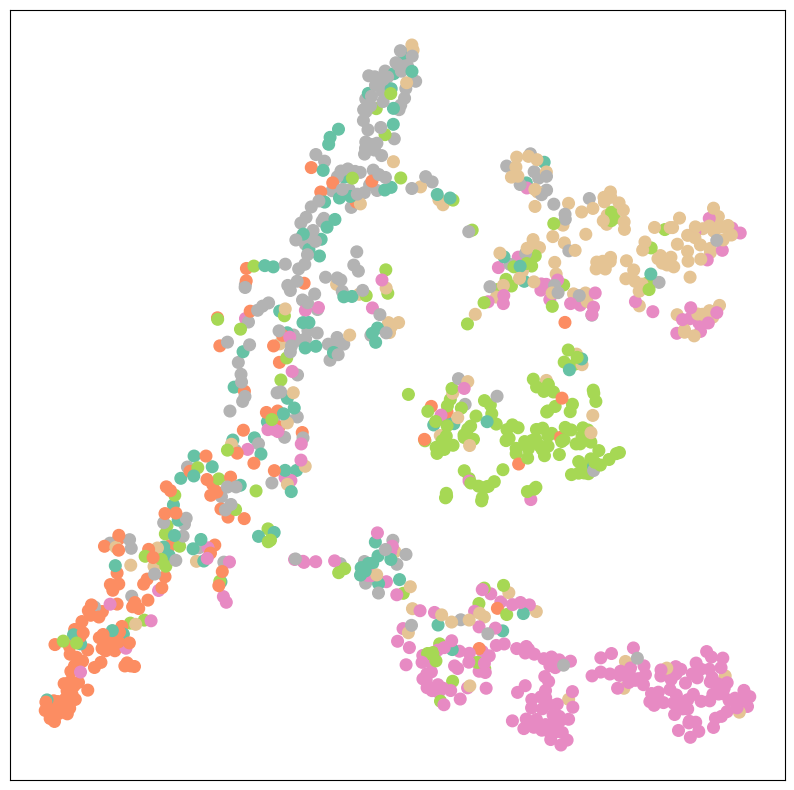

In [ ]:
# Visualize nodes with MLP predictions
model.eval()
out = model(data.x)
visualize(out[data.test_mask], color=data.y[data.test_mask])

## Train Graph Neural Network (GNN)

In [ ]:
from torch_geometric.nn import GCNConv

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(123)
    self.conv1 = GCNConv(data.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, data.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv3(x, edge_index)
    return x

In [ ]:
model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4)

print(model)

GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 6)
)


In [ ]:
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc

In [ ]:
for epoch in range(1, 101):
  loss = train()
  print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 001, Loss: 1.8010
Epoch: 002, Loss: 1.7575
Epoch: 003, Loss: 1.7225
Epoch: 004, Loss: 1.6855
Epoch: 005, Loss: 1.6363
Epoch: 006, Loss: 1.6095
Epoch: 007, Loss: 1.5825
Epoch: 008, Loss: 1.5489
Epoch: 009, Loss: 1.5075
Epoch: 010, Loss: 1.4773
Epoch: 011, Loss: 1.4661
Epoch: 012, Loss: 1.4190
Epoch: 013, Loss: 1.4083
Epoch: 014, Loss: 1.3659
Epoch: 015, Loss: 1.3588
Epoch: 016, Loss: 1.3312
Epoch: 017, Loss: 1.3111
Epoch: 018, Loss: 1.2865
Epoch: 019, Loss: 1.2572
Epoch: 020, Loss: 1.2693
Epoch: 021, Loss: 1.2300
Epoch: 022, Loss: 1.2066
Epoch: 023, Loss: 1.2119
Epoch: 024, Loss: 1.1806
Epoch: 025, Loss: 1.1880
Epoch: 026, Loss: 1.1744
Epoch: 027, Loss: 1.1405
Epoch: 028, Loss: 1.1470
Epoch: 029, Loss: 1.1293
Epoch: 030, Loss: 1.1021
Epoch: 031, Loss: 1.0925
Epoch: 032, Loss: 1.1121
Epoch: 033, Loss: 1.1105
Epoch: 034, Loss: 1.0921
Epoch: 035, Loss: 1.0762
Epoch: 036, Loss: 1.0719
Epoch: 037, Loss: 1.0471
Epoch: 038, Loss: 1.0653
Epoch: 039, Loss: 1.0405
Epoch: 040, Loss: 1.0290


In [ ]:
test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.2374


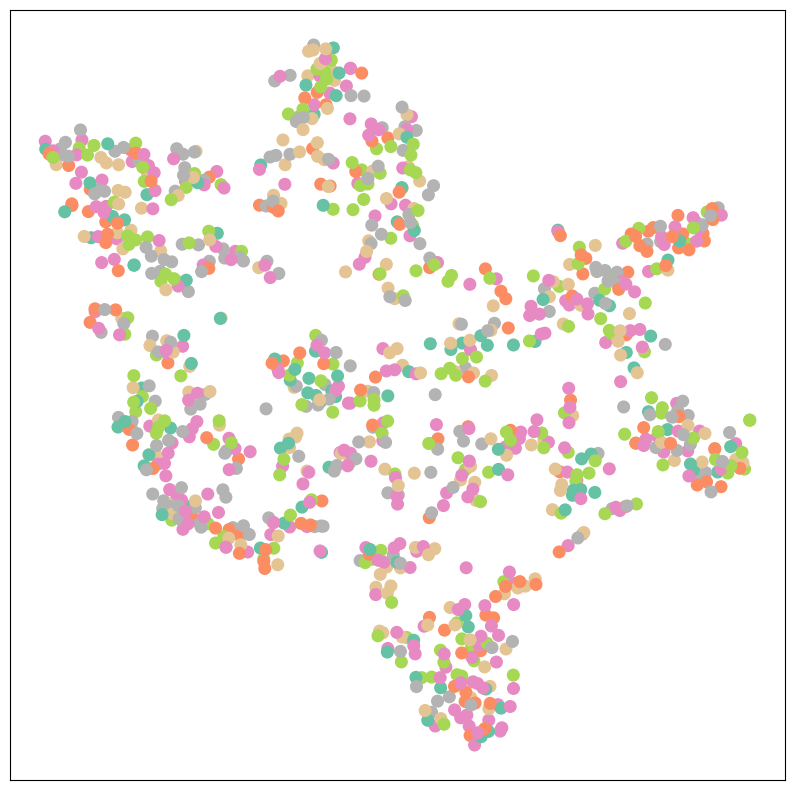

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

##Train a Graph Attention Network (GATConv)

In [ ]:
from torch_geometric.nn import GATConv

In [ ]:
class GAT(torch.nn.Module):
  def __init__(self, hidden_channels, heads):
    super().__init__()
    torch.manual_seed(123)
    self.conv1 = GATConv(in_channels=data.num_features, out_channels=hidden_channels, heads=heads)
    self.conv2 = GATConv(in_channels=hidden_channels * heads, out_channels=hidden_channels, heads=heads)
    self.conv3 = GATConv(in_channels=hidden_channels * heads, out_channels=data.num_classes)

  def forward(self, x, edge_index):
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv3(x, edge_index)
    return x

In [ ]:
model = GAT(hidden_channels=16, heads=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

print(model)

GAT(
  (conv1): GATConv(3703, 16, heads=16)
  (conv2): GATConv(256, 16, heads=16)
  (conv3): GATConv(256, 6, heads=1)
)


In [ ]:
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc


In [ ]:
for epoch in range(1, 101):
  loss = train()
  test_acc = test()
  print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}")

Epoch: 001, Loss: 1.8246, Test: 0.2314
Epoch: 002, Loss: 1.7034, Test: 0.2334
Epoch: 003, Loss: 1.6544, Test: 0.2968
Epoch: 004, Loss: 1.5700, Test: 0.2998
Epoch: 005, Loss: 1.4701, Test: 0.3219
Epoch: 006, Loss: 1.3769, Test: 0.3380
Epoch: 007, Loss: 1.2698, Test: 0.3431
Epoch: 008, Loss: 1.2163, Test: 0.3441
Epoch: 009, Loss: 1.1802, Test: 0.3461
Epoch: 010, Loss: 1.1444, Test: 0.3400
Epoch: 011, Loss: 1.0724, Test: 0.3260
Epoch: 012, Loss: 1.0461, Test: 0.3270
Epoch: 013, Loss: 1.0210, Test: 0.3159
Epoch: 014, Loss: 0.9676, Test: 0.2988
Epoch: 015, Loss: 0.9503, Test: 0.2867
Epoch: 016, Loss: 0.9131, Test: 0.2736
Epoch: 017, Loss: 0.8921, Test: 0.2656
Epoch: 018, Loss: 0.8656, Test: 0.2575
Epoch: 019, Loss: 0.8628, Test: 0.2545
Epoch: 020, Loss: 0.8341, Test: 0.2545
Epoch: 021, Loss: 0.8267, Test: 0.2545
Epoch: 022, Loss: 0.8042, Test: 0.2545
Epoch: 023, Loss: 0.7971, Test: 0.2525
Epoch: 024, Loss: 0.7768, Test: 0.2515
Epoch: 025, Loss: 0.7637, Test: 0.2515
Epoch: 026, Loss: 0.7586,

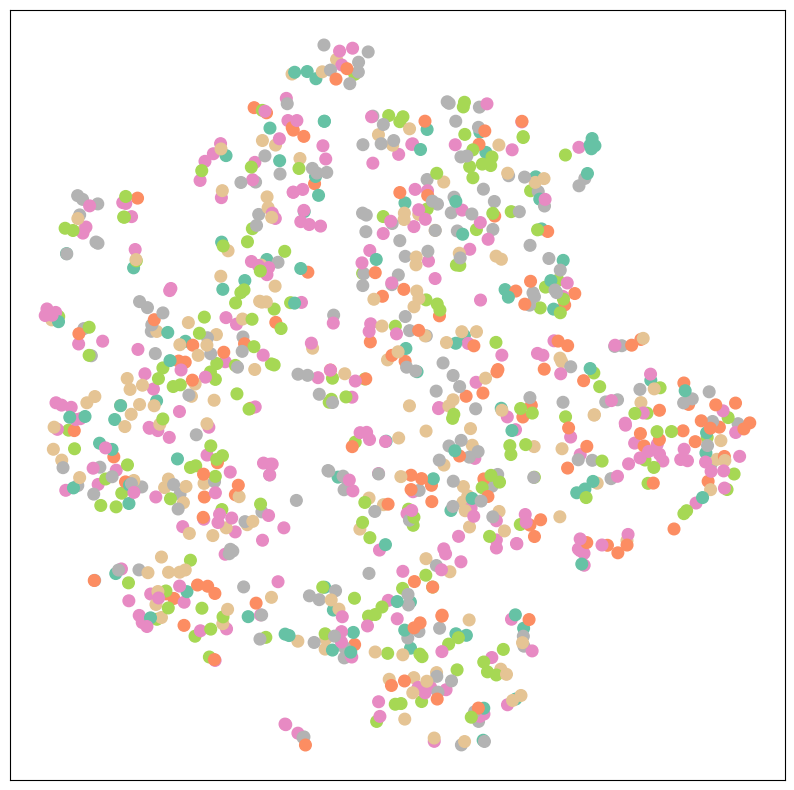

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

In [ ]:
dtest_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.2455
